#Do You Know How to Choose A Good Wine?
**An analysis of wine reviews with location, variety, winery and vintage.**
###Author: Phoebe Tai, Jiejia Ye

##1. Introduction

# Set Up Environment


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Robo Wine Connoisseur

In which two college students attempt to put sommeliers out of a job.

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


#Exploratory Data Analysis

Here are the first five rows of the untouched dataset.

Right off the bat, we're going to eliminate the Taster Name and Twitter Handle columns, as we want to predict the quality of a wine based on production factors, not reviewers. And one would hope a taster's Twitter handle has no bearing on their opinion of a wine.

We are also going to drop the Description column. Although it would have been fun to run these through a natural language processor and see common characteristics of the highest scoring wines, these may be biased by the taster's impression of the wine.
  
Finally, we'll drop the Designation and Region 2 columns, which specify the exact vineyard and subregion in which the grapes are grown, respectively. These are too specific for our purposes, and, from the dataset description, they often have missing values. The rest of the columns may end up being useful to us, so we'll keep them for now.

In [0]:
# Import data
wine_data = pd.read_csv('/content/gdrive/My Drive/wine_data.csv', index_col=0)
wine_data.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [0]:
wine_data.drop(['description', 'designation', 'region_2', 'taster_name', 'taster_twitter_handle'], axis=1, inplace=True)

Now we're going to do some processing to extract the vintage of the wine from the Title column, as this may come in handy when determining quality. This involves a simple regular expression that matches four consecutive integers.

Just to be safe, we'll drop any rows with a vintage greater than 2018 (when this tutorial was written!)

In [0]:
# Extract vintage and drop inaccurate rows
wine_data['vintage'] = pd.to_numeric(wine_data['title'].str.extract(' ([0-9]{4}) ', expand=False))
wine_data = wine_data[wine_data.vintage <= 2018]

# Drop title column
wine_data.drop('title', axis=1, inplace=True)
wine_data.head()

,country,points,price,province,region_1,variety,winery,vintage
0,Italy,87,NaN,Sicily & Sardinia,Etna,White Blend,Nicosia,2013.0
1,Portugal,87,15.0,Douro,NaN,Portuguese Red,Quinta dos Avidagos,2011.0
2,US,87,14.0,Oregon,Willamette Valley,Pinot Gris,Rainstorm,2013.0
3,US,87,13.0,Michigan,Lake Michigan Shore,Riesling,St. Julian,2013.0
4,US,87,65.0,Oregon,Willamette Valley,Pinot Noir,Sweet Cheeks,2012.0


This is looking much better! Finally, let's drop all rows with missing values.

In [0]:
# Drop missing values
wine_data.dropna(inplace=True)
wine_data.head()

,country,points,price,province,region_1,variety,winery,vintage
2,US,87,14.0,Oregon,Willamette Valley,Pinot Gris,Rainstorm,2013.0
3,US,87,13.0,Michigan,Lake Michigan Shore,Riesling,St. Julian,2013.0
4,US,87,65.0,Oregon,Willamette Valley,Pinot Noir,Sweet Cheeks,2012.0
5,Spain,87,15.0,Northern Spain,Navarra,Tempranillo-Merlot,Tandem,2011.0
6,Italy,87,16.0,Sicily & Sardinia,Vittoria,Frappato,Terre di Giurfo,2013.0


Let's try to get a handle on what our data looks like visually, since ~130k wine reviews is not very easily conceptualized. We'll start by plotting the distributions of the two (arguably) most important variables--points and price. We'll also take a look at how they correlate with each other. We expect to get what we pay for, after all!

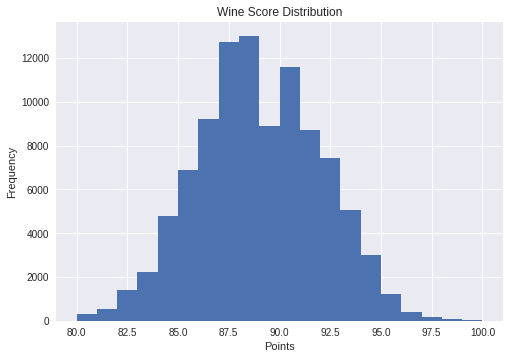

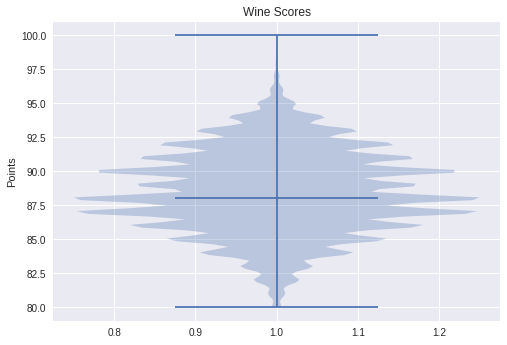

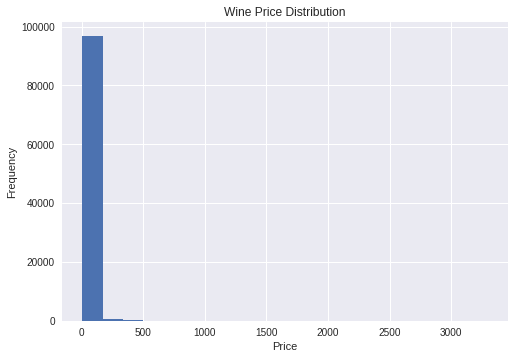

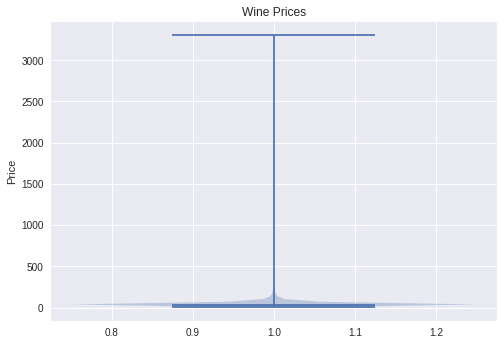

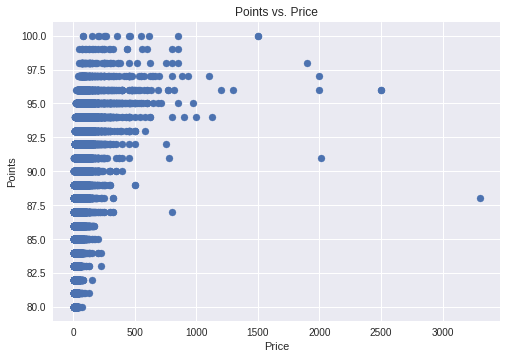

In [0]:
# Plot points histogram
plt.hist(wine_data['points'], bins=20)
plt.title('Wine Score Distribution')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.show()

# Plot points violinplot
plt.axes().violinplot(wine_data['points'], showmedians=True)
plt.title('Wine Scores')
plt.ylabel('Points')
plt.show()

# Plot price histogram
plt.hist(wine_data['price'], bins=20)
plt.title('Wine Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Plot price violinplot
plt.axes().violinplot(wine_data['price'], showmedians=True)
plt.title('Wine Prices')
plt.ylabel('Price')
plt.show()

# Plot points vs price
plt.scatter(wine_data['price'], wine_data['points'])
plt.title('Points vs. Price')
plt.xlabel('Price')
plt.ylabel('Points')
plt.show()

There are quite a few things to note here. First, the wine scores have an approximately normal distribution, which is about what we'd expect. The author of this dataset noted that Wine Enthusiast Magazine (the source of these reviews) doesn't publish reviews of wines that receive fewer than 80 points, which is why the range of these values only runs from 80 to 100.

Secondly, the price histogram is looking a little...odd. Upon closer examination of the corresponding violin plot, we can see that at least one data point is throwing off our graphs, with a whopping price of about $3,500! The vast majority of wines reviewed are more reasonably priced, rarely exceeding 250 per bottle.

The final scatter plot is perhaps the most revealing. It shows that while expensive wines are more likely to get high scores, cheaper wines are certainly capable of scoring just as well.

Just for fun, let's see where most of our wines originate from!

#The Most Popular Series


In [0]:
# Have a general idea about how the data looks like
wine_data.country.unique().size
wine_data.province.unique().size
wine_data.region_1.unique().size
wine_data.variety.unique().size
wine_data.winery.unique().size
count = {'country':wine_data.country.unique().size, 'province': wine_data.province.unique().size, 'region':wine_data.region_1.unique().size,
        'variety': wine_data.variety.unique().size, 'winery':wine_data.winery.unique().size}
print(count)

{'country': 7, 'province': 62, 'region': 1194, 'variety': 500, 'winery': 13394}


## The most popular wine by country of origin

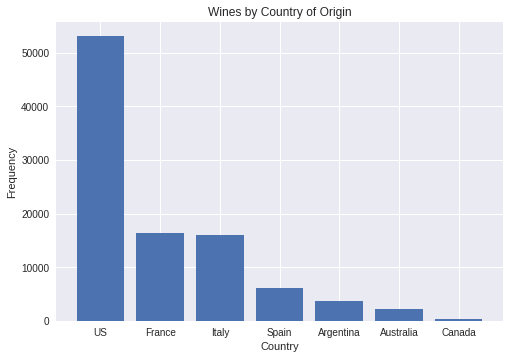

In [0]:
# Group data by country and count occurrences
countries = wine_data.groupby('country').size().reset_index()
countries.columns = ['country', 'count']
countries = countries.sort_values('count',ascending=False)
xpose = countries['country']
ypose = countries['count']

# Plot bar graph
plt.bar(range(len(xpose)), list(map(float,ypose)), align = 'center')
plt.xticks(range(len(xpose)), xpose)
plt.title('Wines by Country of Origin')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.show()

## The most popular wine by province of origin

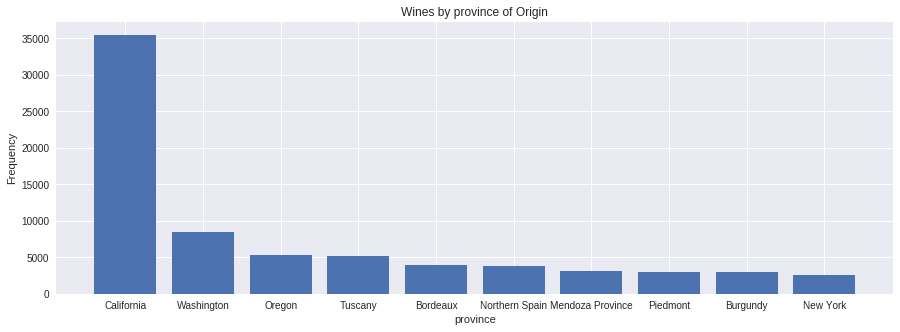

In [0]:
province = wine_data.groupby('province').size().reset_index()
province.columns = ['province', 'count']
province = province.sort_values('count',ascending=False)
xpose = province['province'][:10]
ypose =province['count'][:10]

# Plot bar graph
plt.figure(figsize=(15, 5))
plt.bar(range(len(xpose)), list(map(float,ypose)), align = 'center')
plt.xticks(range(len(xpose)), xpose)
plt.title('Wines by province of Origin')
plt.xlabel('province')
plt.ylabel('Frequency')
plt.show()

Seems like the majority of them are from the United States, with France and Italy vying for second and third place.

## The Most Popular Variety

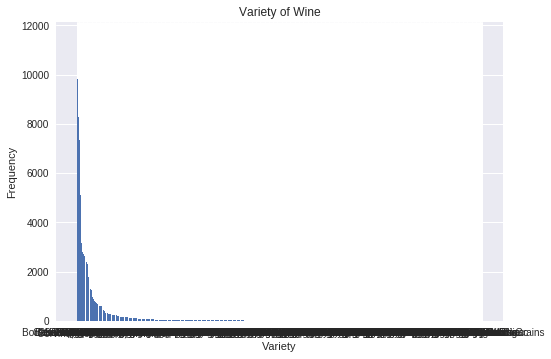

In [0]:
# The Most Popular Variety
var = wine_data.groupby('variety').size().reset_index()
var.columns = ['variety', 'count']
var = var.sort_values('count',ascending=False)
xpose = var['variety']
ypose = var['count']
# Plot bar graph
plt.bar(range(len(xpose)), list(map(float,ypose)), align = 'center')
plt.xticks(range(len(xpose)), xpose)
plt.title('Variety of Wine')
plt.xlabel('Variety')
plt.ylabel('Frequency')
plt.show()

We've shown that there are 500 hundred different types of variety. The visualization of all types of variety is unrealistic. So now we will present the top 10 popular types of variety

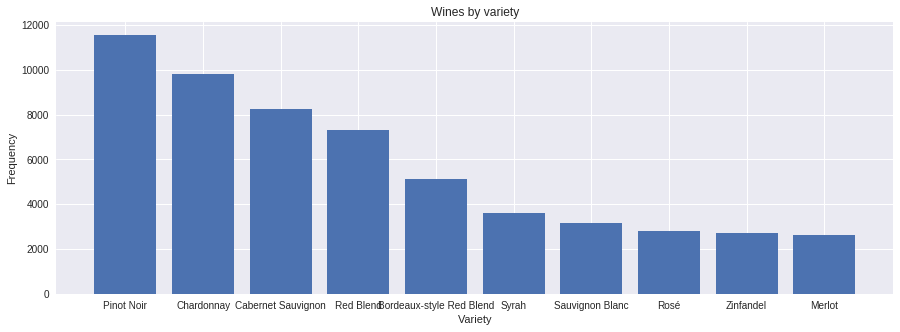

In [0]:
xpose = xpose[:10]
ypose = ypose[:10]

# Plot bar graph
plt.figure(figsize=(15, 5))
plt.bar(range(len(xpose)), list(map(float,ypose)))
plt.xticks(range(len(xpose)), xpose)
plt.title('Wines by variety')
plt.xlabel('Variety')
plt.ylabel('Frequency')
plt.show()

Variety is the type of grapes used for wine. Based on the graph above, people like the taste of pinot noir the best. So what is pinot noir and why do people like it?  Joel Fleischman once described that " pinot noir is the most romantic of wines, with so voluptuous a perfume, so sweet an edge, and so powerful a punch that, like falling in love, they make the blood run hot and the soul wax embarrassingly poetic." And clicking into the following link, you will find more fun fact about pinot noir.
https://www.vivino.com/wine-news/10-unmissable-facts-about-pinot-noir-grapes-wines

##The Most Popular Winery

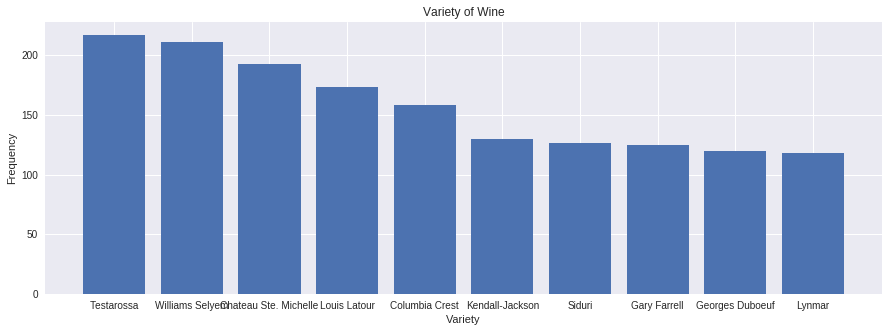

In [0]:
# The most popular winery
winery = wine_data.groupby('winery').size().reset_index()
winery.columns = ['winery', 'count']
winery = winery.sort_values('count',ascending=False)

xpose = winery['winery'][:10]
ypose = winery['count'][:10]

# Plot bar graph
plt.figure(figsize=(15, 5))
plt.bar(range(len(xpose)), list(map(float,ypose)))
plt.xticks(range(len(xpose)), xpose)
plt.title('Variety of Wine')
plt.xlabel('Variety')
plt.ylabel('Frequency')
plt.show()

Now let's make some predictions!

#Random Forest Regression

Before we begin applying any machine learning models, we're going to need to one-hot encode our data. This means converting all our categorical variables to binary ("dummy") variables, so that our algorithms know what to do with them! Luckily, this can be done in a single line.

In [0]:
# drop winery for now (too many values)
wine_data.drop('winery', axis=1, inplace=True)

# One-hot encode categorial variables
encoded = pd.get_dummies(wine_data)
encoded.head()


,points,price,vintage,country_Argentina,country_Australia,country_Canada,country_France,country_Italy,country_Spain,country_US,...,variety_Vitovska,variety_Viura,variety_Viura-Chardonnay,variety_Viura-Verdejo,variety_White Blend,variety_White Riesling,variety_Xarel-lo,variety_Zibibbo,variety_Zinfandel,variety_Zweigelt
2,87,14.0,2013.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,87,13.0,2013.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,87,65.0,2012.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,87,15.0,2011.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,87,16.0,2013.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


We will also want to establish a baseline estimate, so we'll have something to compare our results against later. This will involve the highly scientific approach of averaging the points, then using that average as an estimate for every single wine in our dataset. If our machine learning models are unable to surpass this incredibly naive "algorithm", it's a sign that we need to reevaluate our approach.

In [0]:
# Calculate average score
baseline = wine_data['points'].mean()

Now let's try using a random forest to predict wine ratings. Random forests are known for their high accuracy, and serve as a fairly efficient way to analyze large datasets such as ours. We'll start with the default 75:25 split, with 75% of our data being used for training, and the other 25% for testing, and 100 trees. We can fine-tune these later if necessary.

In [0]:
# Split data into features (input) and labels (output)
labels = encoded['points']
features = np.array(encoded.drop('points', axis=1))

# Split data 75:25 into train and test sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

# Train
regr = RandomForestRegressor(n_estimators=100)
regr.fit(train_features, train_labels)

In [0]:
# test
pred = regr.predict(test_features)
err = mean_squared_error(test_labels, pred)
print(err)

In [0]:
# Have a general idea about how the data looks like
wine_data.country.unique().size
wine_data.province.unique().size
wine_data.region_1.unique().size
wine_data.variety.unique().size
wine_data.winery.unique().size
count = {'country':wine_data.country.unique().size, 'province': wine_data.province.unique().size, 'region':wine_data.region_1.unique().size,
        'variety': wine_data.variety.unique().size, 'winery':wine_data.winery.unique().size}
print(count)

## **Plot Correlation Heatmap**

Since there are too many varieties and wineries. And a lot of varieties and wineries only has several reviews which has no meaning in statistics. In order to effectively train our machine learning model, we will find top ten value in each variable and group the rest of values as ''other".

In [0]:
# create a map to replace the categorical variable with their ranks. Rank 1 represents the highest freqency.
wine_data.variety.value_counts()
top = 50

country = wine_data.country.value_counts().index[:]
country= pd.Series([1,2,3,4,5,6,7],index = country)

prov = wine_data.province.value_counts().index[0:top]
prov= pd.Series(range(1,top+1),index = prov)

region = wine_data.region_1.value_counts().index[0:top]
region = pd.Series(range(1,top+1),index = region)

variety = wine_data.variety.value_counts().index[0:top]
variety = pd.Series(range(1,top+1),index = variety)

winery = wine_data.winery.value_counts().index[0:top]
winery = pd.Series(range(1,top+1),index = winery)


In [0]:
copy = wine_data.replace({'country':country, 'province':prov,'region_1':region, 'variety':variety, 'winery':winery})
copy['province'] = pd.to_numeric(copy['province'],errors='coerce').fillna(0)
copy['region_1'] = pd.to_numeric(copy['region_1'],errors='coerce').fillna(0)
copy['variety'] = pd.to_numeric(copy['variety'],errors='coerce').fillna(0)
copy['winery'] = pd.to_numeric(copy['winery'],errors='coerce').fillna(0)

numeric_data =  copy.drop(['description'],axis=1)
numeric_data.head()

In [0]:
# plot correlation heatmap
wine_corr = numeric_data.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(wine_corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           cmap= 'coolwarm')
plt.title('Correlation between features');

Correlation graph above visualizes how different features correlated with each other. We can see that country and province are highly correlated. And the linearly correlated features contain redundant information. In order to increase efficiency and avoid bias, we only need one features to train the prediction model.